# Table of contents
1. [Introduction](#introduction)
2. [Data Preparation](#Data-Preparation)
    1. [Prepare a reduced version of the data](#Data-Preparation)
    2. [Data Cleaning](#Data-Cleaning)
    3. [Data Description](#Data-Description)
    4. [Save the cleaned data to a sql database](#Save-the-cleaned-data-to-a-sql-database)
3. [Data Analysis using SQL and Python](#Data-Analysis-using-SQL-and-Python)
    1. [Suggestion 1 about mean visited pages and the ratio of users only visiting pages](#Suggestion1)
    2. [Suggestion 2 about funnel analysis](#Suggestion2)
    3. [Suggustion 3 about users daily and hourly patterns](#Suggestion3)
    4. [Suggustion 4 about customer purchase times and VIP customers](#Suggestion4)
    5. [Suggustion 5 about item sold times and best sellers](#Suggestion5)
    


<a name="introduction"></a>
## Introduction
This case is about the Chinese most popular online shopping website (Taobao, like Amazon) which has a huge customer base. Millions of customeres are shopping online with behaviors such as click, purchase, adding item to shopping cart and item favoring. This notebook analyzed user behaviors data to understand customers and gave recommendations to improve sales.


## Goal:
1. Conduct funnel analysis and find which step most users stop before making purchases
2. Study users daily and hourly patterns and find user active hours and days
3. Find VIP customers and best sellers and give corresponding suggestions to improve sales

### Note: 
The original dataset can be downloaded from [here](https://tianchi.aliyun.com/dataset/dataDetail?dataId=649&userId=1)

In [1]:
import sqlite3 as db
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

<a name="Data Preparation"></a>
## Data Preparation
###  Prepare a reduced version of the data

Original data (UserBehavior.csv) contains 1 million users' behaviors during November 25 to December 03, 2017, with 100,150,807 entries, and a memory use over 3.7 GB. <br>
Prepare a reduced version of the data (UserBehavior_reduced_data.csv) by taking the first 1.05 million rows of entries from the original data.<br>

In [2]:
#df = pd.read_csv('UserBehavior.csv',header=None)

In [3]:
#df.head(3)
#Output

#0	1	2268318	2520377	pv	1511544070
#1	1	2333346	2520771	pv	1511561733
#2	1	2576651	149192	pv	1511572885

# Note: Data is ordered by user id (1 is user_id in the output above). 
# Reduced data should be taken in order, not by random sampling.

In [4]:
# df = df[:1050000]

In [5]:
# df.to_csv('UserBehavior_reduced_data.csv',index=False)

<a name="Data Cleaning"></a>
### Data Cleaning
Add date and hour columns and remove entries outsided of the pre-defined time frame. <br>
See the following data description part to understand the data. <br>

In [6]:
df = pd.read_csv('UserBehavior_reduced_data.csv',header=0)

In [7]:
df = df.rename(columns={'0':'User_id','1':'Item_id','2':'Category_id','3':'Behavior','4':'Time'})
df.head(3)

,User_id,Item_id,Category_id,Behavior,Time
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885


In [8]:
df['Date_all']=pd.to_datetime(df.Time.values,unit='s',utc=True).tz_convert('Asia/Shanghai')
df['Date']=df['Date_all'].astype('str').str[:10]
df['Hour']=df['Date_all'].astype('str').str[11:13]

del df['Date_all']

df['Hour']=df['Hour'].astype('int64')
#df['Date']=pd.to_datetime(df['Date'])

In [9]:
df.head(3)

,User_id,Item_id,Category_id,Behavior,Time,Date,Hour
0,1,2268318,2520377,pv,1511544070,2017-11-25,1
1,1,2333346,2520771,pv,1511561733,2017-11-25,6
2,1,2576651,149192,pv,1511572885,2017-11-25,9


In [10]:
df=df[(df['Date']>='2017-11-25')&(df['Date']<='2017-12-03')]

<a name="Data Description"></a>
### Data Description
User_id: User ID<br>
Item_id: Item ID<br>
Category_id: Category ID corresponding to the item<br>
Behavior: Four kinds of behaviros: 'pv', 'buy', 'cart', 'fav'<br>
'pv': page view / click; 'buy': purchase; 'cart': adding item to shopping cart; 'fav': item favoring <br>
Timestamp: The timestamp of the behavior<br>
Date: The date of the behavior<br>
Hour: The hour of the behavior in a 24-hour clock<br>

In [11]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

User_id              10213	 [1, 13, 100, 115, 117]
Item_id              412582	 [72, 81, 87, 101, 115]
Category_id           5856	 [2171, 2410, 3579, 4907, 5064]
Behavior                 4	 ['buy', 'cart', 'fav', 'pv']
Time                 509064	 [1511539200, 1511539201, 1511539202, 1511539203, 1511539204]
Date                     9	 ['2017-11-25', '2017-11-26', '2017-11-27', '2017-11-28', '2017-11-29']
Hour                    24	 [0, 1, 2, 3, 4]


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049489 entries, 0 to 1049999
Data columns (total 7 columns):
User_id        1049489 non-null int64
Item_id        1049489 non-null int64
Category_id    1049489 non-null int64
Behavior       1049489 non-null object
Time           1049489 non-null int64
Date           1049489 non-null object
Hour           1049489 non-null int64
dtypes: int64(5), object(2)
memory usage: 64.1+ MB


In [13]:
df.describe()

,User_id,Item_id,Category_id,Time,Hour
count,1.049489e+06,1.049489e+06,1.049489e+06,1.049489e+06,1.049489e+06
mean,4.150789e+05,2.577360e+06,2.706688e+06,1.511962e+09,1.489897e+01
std,4.301022e+05,1.488909e+06,1.464153e+06,2.302779e+05,6.112060e+00
min,1.000000e+00,7.200000e+01,2.171000e+03,1.511539e+09,0.000000e+00
25%,1.094910e+05,1.292046e+06,1.349561e+06,1.511762e+09,1.100000e+01
50%,1.225630e+05,2.575178e+06,2.692253e+06,1.511966e+09,1.600000e+01
75%,1.004751e+06,3.861679e+06,4.145813e+06,1.512180e+09,2.000000e+01
max,1.018011e+06,5.163057e+06,5.161669e+06,1.512317e+09,2.300000e+01


<a name="Save the cleaned data to a sql database"></a>
### Save the cleaned data to a sql database

In [14]:
conn = db.connect('Users.db')
c = conn.cursor()

In [15]:
c.execute("DROP TABLE IF EXISTS user_behavior")

df.to_sql('user_behavior',conn)

In [16]:
query = '''
    SELECT * 
    FROM user_behavior
    LIMIT 3
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Index','User_id','Item_id','Category_id','Behavior','Time','Date','Hour'])

,Index,User_id,Item_id,Category_id,Behavior,Time,Date,Hour
0,0,1,2268318,2520377,pv,1511544070,2017-11-25,1
1,1,1,2333346,2520771,pv,1511561733,2017-11-25,6
2,2,1,2576651,149192,pv,1511572885,2017-11-25,9


<a name="Data Analysis using SQL and Python"></a>
## Data Analysis using SQL and Python

In [17]:
query = '''
    SELECT 
    (SELECT COUNT(*) FROM user_behavior WHERE behavior = 'pv') AS total_visited_pages_count, 
    COUNT(DISTINCT user_id) AS unique_users_count, 
    (SELECT COUNT(*) AS total_visited_pape_number FROM user_behavior WHERE behavior = 'pv') / 
    (SELECT COUNT(DISTINCT user_id)) AS mean_visited_pages
    FROM user_behavior

'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Total_visited_pages_count','Unique_users_count','Mean_visited_pages'])

,Total_visited_pages_count,Unique_users_count,Mean_visited_pages
0,940828,10213,92


In [18]:
query = '''
    SELECT COUNT(DISTINCT t1.user_id), t2.Count_users_only_visiting_pages
    FROM (SELECT user_id
    FROM user_behavior) AS t1
    LEFT JOIN
    (SELECT user_id, COUNT(DISTINCT user_id) as Count_users_only_visiting_pages
    FROM user_behavior
    WHERE user_id NOT IN(SELECT DISTINCT user_id FROM user_behavior WHERE behavior = 'fav')
    AND user_id NOT IN(SELECT DISTINCT user_id FROM user_behavior WHERE behavior = 'cart')
    AND user_id NOT IN(SELECT DISTINCT user_id FROM user_behavior WHERE behavior = 'buy')) AS t2
    ON t1.user_id = t2.user_id
'''
c.execute(query)
results=c.fetchall()


pd.DataFrame(results,columns=['Count_total_users','Count_users_only_visiting_pages'])

,Count_total_users,Count_users_only_visiting_pages
0,10213,588


<a name="Suggestion1"></a>
### Suggestion 1 about mean visited pages and the ratio of users only visiting pages
1. Mean visited pages is 92, pretty high, showing that users spend lots of time on clicking in the given 9 days period. <br>
2. The ratio of users only visiting pages in total users is 5.76% (=588/10213), pretty low, showing that most users did favoring items, putting items in a cart or making a purchase in the given 9 days period.

In [19]:
query = '''
    SELECT behavior, COUNT(*)
    FROM user_behavior
    GROUP BY behavior
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Behavior','Users_count'])

,Behavior,Users_count
0,buy,21337
1,cart,57936
2,fav,29388
3,pv,940828


In [20]:
from pyecharts import options as opts
from pyecharts.charts import Funnel
from pyecharts.faker import Faker

attr = ['Page_view', 'Cart', 'Favorite', 'Buy']
value = [940828, 57936 , 29388, 21337]    
funnel = Funnel()
funnel.add("Conversion Funnel 1", [list(z) for z in zip(attr, value)])
funnel.set_global_opts(title_opts=opts.TitleOpts(title="Conversion Funnel 1"))
funnel.render("funnel_base.html") 
funnel.render_notebook()

C:\Users\haoxu\Anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [21]:
query = '''
    SELECT behavior, COUNT(DISTINCT user_id)
    FROM user_behavior
    GROUP BY behavior
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Behavior','Unique_users_count'])

,Behavior,Unique_users_count
0,buy,7010
1,cart,7675
2,fav,4072
3,pv,10180


In [22]:
from pyecharts import options as opts
from pyecharts.charts import Funnel
from pyecharts.faker import Faker

attr = ['Page_view', 'Cart', 'Favorite', 'Buy']
value = [10180, 7675, 4072, 7010]    
funnel = Funnel()
funnel.add("Conversion Funnel 2", [list(z) for z in zip(attr, value)])
funnel.set_global_opts(title_opts=opts.TitleOpts(title="Conversion Funnel 2"))
funnel.render("funnel_base2.html") 
funnel.render_notebook()

C:\Users\haoxu\Anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


<a name="Suggestion2"></a>
### Suggestion 2 about funnel analysis
1. According to the first conversion funnel, without grouping users (10 page views/user_id counted as 10), only 6.2% (=57936/940828) of customers added items to shopping carts after page viewing. This shows that customers spend lots of time on viewing items. One suggestion to improve the ratio is to optimize the screening function that helps customers to find items faster. When items are in the shopping carts, 36.8% (=21337/57936) of customers made purchases. The step ratio is high, and should be compared to benchmark or historical value.<br>  
2. According to the second conversion funnel, with grouping users (10 page views/user_id counted as 1), after page viewing, 75.4% (=7675/10180) of customers added items to shopping carts, then 91.3% (=7010/7675) of customers made purchases. This shows that customers are likly to purchase items on this website after viewing them.

In [23]:
query = '''
    SELECT t1.date,t1.page_views,t1.cart_count,t1.fav_count,t1.buy_count,t2.count_users,t3.count_users_making_purchaces
    FROM(SELECT date,SUM(CASE WHEN behavior='pv' THEN 1 ELSE 0 END) AS page_views,
    SUM(CASE WHEN behavior='cart' THEN 1 ELSE 0 END)AS cart_count,
    SUM(CASE WHEN behavior='fav' THEN 1 ELSE 0 END)AS fav_count,
    SUM(CASE WHEN behavior='buy' THEN 1 ELSE 0 END)AS buy_count
    FROM user_behavior
    GROUP BY date)AS t1
    LEFT JOIN
    (SELECT date,COUNT(DISTINCT user_id)AS count_users
    FROM user_behavior
    GROUP BY date)AS t2
    ON t1.date=t2.date
    LEFT JOIN(SELECT date,COUNT(DISTINCT user_id)AS count_users_making_purchaces
    FROM user_behavior
    WHERE behavior='buy'
    GROUP BY date)AS t3
    ON t1.date=t3.date
    ORDER BY t1.date
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Date','Page_views','Cart_count','Fav_count','Purchase_count','Count_total_unique_users','Count_unique_users_making_purchaces'])

,Date,Page_views,Cart_count,Fav_count,Purchase_count,Count_total_unique_users,Count_unique_users_making_purchaces
0,2017-11-25,98631,6035,2854,2083,7309,1387
1,2017-11-26,100677,6051,3235,2109,7483,1390
2,2017-11-27,91678,5699,2977,2336,7367,1478
3,2017-11-28,93034,5782,2843,2310,7363,1473
4,2017-11-29,95787,5802,3177,2404,7480,1537
5,2017-11-30,99713,5906,3041,2447,7586,1558
6,2017-12-01,102674,6337,3145,2262,7631,1488
7,2017-12-02,129690,8205,4112,2649,10031,1814
8,2017-12-03,128944,8119,4004,2737,10028,1850


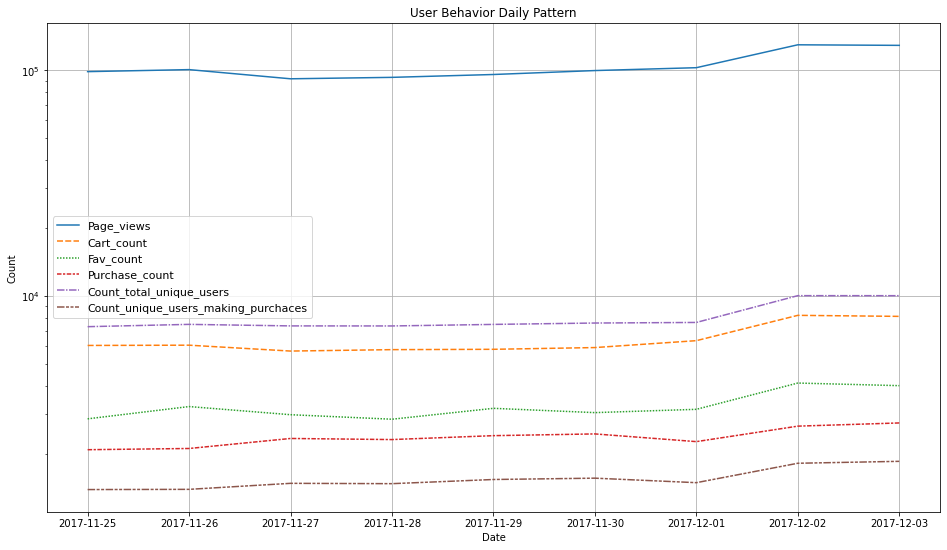

In [24]:
plt_data = pd.DataFrame(results,columns=['Date','Page_views','Cart_count','Fav_count','Purchase_count','Count_total_unique_users','Count_unique_users_making_purchaces'])
plt_data = plt_data.set_index('Date')
f, ax = plt.subplots(figsize=(16,9))
ax.set(yscale="log")
sns.set_context("notebook")

g = sns.lineplot(data=plt_data.iloc[:,:])
ax.set_title('User Behavior Daily Pattern')
ax.set_ylabel('Count')
ax.grid()

plt.show()

In [25]:
query = '''
    SELECT t1.hour,t1.page_views,t1.cart_count,t1.fav_count,t1.buy_count,t2.count_users,t3.count_users_making_purchaces
    FROM(SELECT hour,SUM(CASE WHEN behavior='pv' THEN 1 ELSE 0 END) AS page_views,
    SUM(CASE WHEN behavior='cart' THEN 1 ELSE 0 END)AS cart_count,
    SUM(CASE WHEN behavior='fav' THEN 1 ELSE 0 END)AS fav_count,
    SUM(CASE WHEN behavior='buy' THEN 1 ELSE 0 END)AS buy_count
    FROM user_behavior
    GROUP BY hour)AS t1
    LEFT JOIN
    (SELECT hour,COUNT(DISTINCT user_id)AS count_users
    FROM user_behavior
    GROUP BY hour)AS t2
    ON t1.hour=t2.hour
    LEFT JOIN(SELECT hour,COUNT(DISTINCT user_id)AS count_users_making_purchaces
    FROM user_behavior
    WHERE behavior='buy'
    GROUP BY hour)AS t3
    ON t1.hour=t3.hour
    ORDER BY t1.hour
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Hour','Page_views','Cart_count','Fav_count','Purchase_count','Count_total_unique_users','Count_unique_users_making_purchaces'])

,Hour,Page_views,Cart_count,Fav_count,Purchase_count,Count_total_unique_users,Count_unique_users_making_purchaces
0,0,31702,1920,1016,598,3234,400
1,1,14522,934,458,248,1695,164
2,2,8324,532,273,152,1025,93
3,3,5829,391,185,65,728,47
4,4,5157,273,170,91,653,57
5,5,6324,395,226,79,893,64
6,6,12717,887,537,176,1838,133
7,7,23408,1551,721,408,3415,315
8,8,31802,1956,1026,678,4585,507
9,9,39130,2429,1305,1020,5426,751


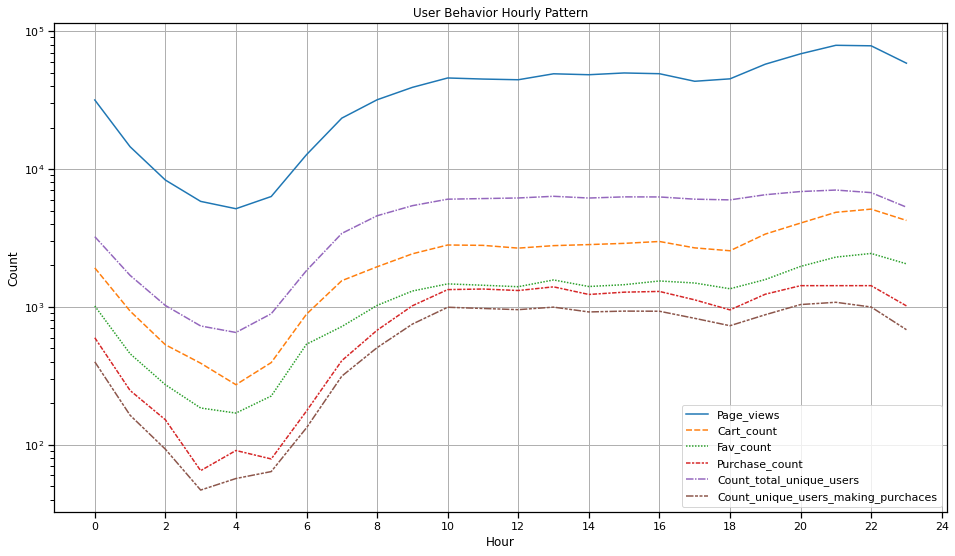

In [26]:
plt_data = pd.DataFrame(results,columns=['Hour','Page_views','Cart_count','Fav_count','Purchase_count','Count_total_unique_users','Count_unique_users_making_purchaces'])
plt_data = plt_data.set_index('Hour')
f, ax = plt.subplots(figsize=(16,9))
ax.set(yscale="log")
sns.set_context("notebook")

g = sns.lineplot(data=plt_data.iloc[:,:])
ax.set_title('User Behavior Hourly Pattern')
ax.set_ylabel('Count')
ax.grid()

g.set(xticks=[2*i for i in range(13)])

plt.show()

<a name="Suggestion3"></a>
### Suggustion 3 about users daily and hourly patterns
1. According to user behavior daily pattern, behavior counts and user counts were all increaed 20-30% on the weekend of Dec. 2rd and Dec. 3rd in 2017, not the previous weekend of Nov. 25h and Nov. 26 in 2017. A comparison study should conducted to understand what kind of factors lead this positive change.<br>
2. According to user behavior hourly pattern, behavior counts and user counts were low between 0-8 o'clock, and back to normal between 10-16 o'clock, and 10% higher than normal between 20-22 o'clock. Major events like live streaming promotions should better be hold between 20-22 o'clock, not around 18 o'clock or after 22 o'clock.

In [27]:
query = '''
    SELECT t1.purchase_count, COUNT(t1.user_id) as user_count
    FROM
    (SELECT user_id, COUNT(user_id) AS purchase_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY user_id) AS t1
    GROUP BY t1.purchase_count
    ORDER BY t1.purchase_count

'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Number_of_purchases','Users_count'])

,Number_of_purchases,Users_count
0,1,2365
1,2,1650
2,3,1095
3,4,643
4,5,402
5,6,270
6,7,176
7,8,104
8,9,75
9,10,50


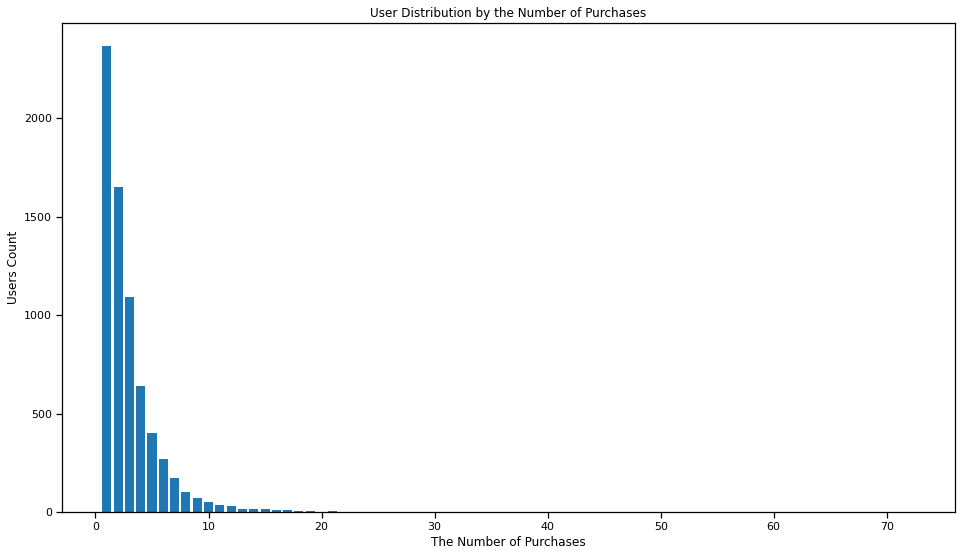

In [28]:
plt_data = pd.DataFrame(results,columns=['Number_of_purchases','Users_count'])

f, ax = plt.subplots(figsize=(16,9))

plt.bar(plt_data['Number_of_purchases'],plt_data['Users_count'])
ax.set_title('User Distribution by the Number of Purchases')
ax.set_ylabel('Users Count')
ax.set_xlabel('The Number of Purchases')

plt.show()

In [29]:
query = '''
    SELECT user_id, count(*) as purchase_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY user_id
    ORDER BY purchase_count DESC
    LIMIT 10
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Customer_IDs_buying_most','Purchase_count'])

,Customer_IDs_buying_most,Purchase_count
0,107932,72
1,122504,69
2,128379,65
3,1008380,57
4,1003983,43
5,108865,36
6,128113,32
7,1003901,31
8,114948,31
9,1010288,30


In [30]:
query = '''
    SELECT t1.category_id, COUNT(t1.category_id) AS purchase_count
    FROM
    (SELECT category_id, user_id
    FROM user_behavior
    WHERE behavior = 'buy'
    ) AS t1
    INNER JOIN (SELECT user_id, count(*) as purchase_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY user_id
    ORDER BY purchase_count DESC
    LIMIT 10
    ) AS t2
    on t1.user_id = t2.user_id
    GROUP BY t1.category_id
    ORDER BY purchase_count DESC
    LIMIT 10

'''
c.execute(query)
results=c.fetchall()

results
pd.DataFrame(results,columns=['Popular_catogorie_IDs_in_top10_customers','Purchase_count'])

,Popular_catogorie_IDs_in_top10_customers,Purchase_count
0,901282,35
1,1575622,13
2,3975787,8
3,2440115,7
4,4756105,6
5,2465336,5
6,1080785,5
7,4718907,4
8,4515486,4
9,4222240,4


<a name="Suggestion4"></a>
### Suggustion 4 about customer purchase times and VIP customers
1. According to user distribution by the number of purchases, for customers who bought items, 34% (=2365/7010) of them bought once, and 82% of them bought four times or less, and surprisingly 1 customer bought 72 times in the given 9 days. That fact that 66% (=1-34%) of customers bought 2 times or more shows that customers developed a good online shopping habit.
2. For VIP customers who bought lots of items, there are two recommendations: First, analyze these VIP customers data to find if they are malicious or fake. Second, recommend true VIP customers more items that are popular among VIP customers.

In [31]:
query = '''
    SELECT t1.purchase_count, COUNT(t1.item_id) as item_count
    FROM
    (SELECT item_id, COUNT(item_id) AS purchase_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY item_id) AS t1
    GROUP BY t1.purchase_count
    ORDER BY t1.purchase_count
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Number_of_purchases','Items_count'])

,Number_of_purchases,Items_count
0,1,16200
1,2,1659
2,3,324
3,4,106
4,5,28
5,6,14
6,7,15
7,8,3
8,9,1
9,10,1


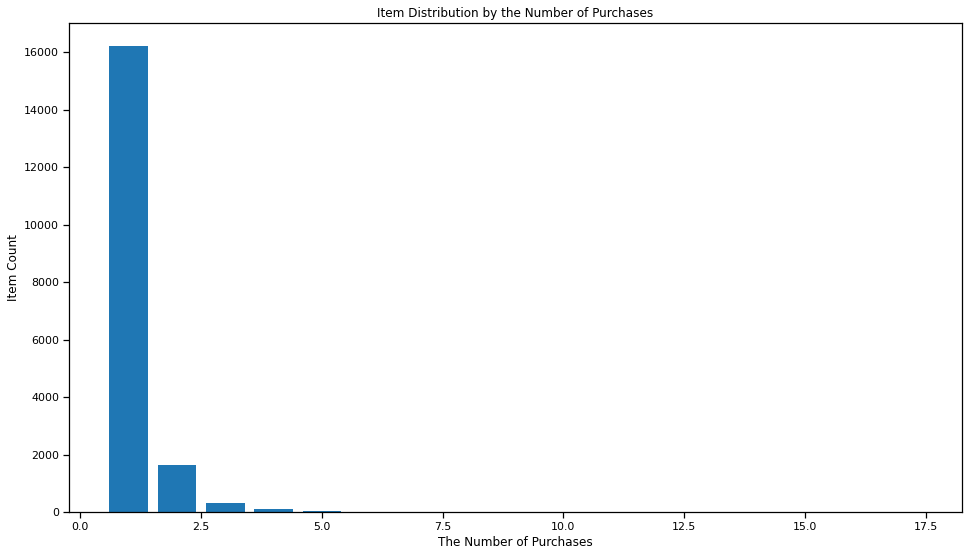

In [32]:
plt_data = pd.DataFrame(results,columns=['Number_of_purchases','Items_count'])

f, ax = plt.subplots(figsize=(16,9))

g = plt.bar(plt_data['Number_of_purchases'],plt_data['Items_count'])
ax.set_title('Item Distribution by the Number of Purchases')
ax.set_ylabel('Item Count')
ax.set_xlabel('The Number of Purchases')

range_number = int(plt_data['Number_of_purchases'].max()+1)


plt.show()

In [33]:
query = '''
    SELECT item_id, count(*) as sales_count
    FROM user_behavior
    WHERE behavior = 'buy'
    GROUP BY item_id
    ORDER BY sales_count DESC
    LIMIT 5
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Best_sellers','Sales_count'])


,Best_sellers,Sales_count
0,3122135,17
1,3237415,12
2,2964774,11
3,2124040,11
4,4401268,10


In [34]:
query = '''
    SELECT item_id, COUNT(user_id) AS total_views
    FROM user_behavior
    WHERE behavior = 'pv'
    GROUP BY item_id
    ORDER BY total_views DESC
    LIMIT 5
'''
c.execute(query)
results=c.fetchall()

pd.DataFrame(results,columns=['Top_items_being_viewed','Total_views'])

,Top_items_being_viewed,Total_views
0,812879,298
1,138964,233
2,3845720,231
3,3708121,205
4,2331370,198


<a name="Suggestion5"></a>
### Suggustion 5 about item sold times and best sellers
1. According to item distribution by the number of purchases, for items sold, 88% (=16200/18355) of them were sold once and best seller #1 was sold 17 times . This shows that long tail products account for most sales.
2. Top 5 items being viewed did not contain any of best 5 sellers. Pages of top items being viewed should be optimized to improve conversion rate.